# Image Classification with CNN + Keras 

In [30]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os

In [9]:
# initialize the number of epochs to train for, initial learning rate, batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)
# initialize the data and labels
data = []
labels = []
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


# Data Preprocessing

In [10]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    # extract the class label from the image path and update the labels list
    # the files are stored as dataset/{CLASS_LABEL}/{FILENAME}.jpg => split will convert it to an array and the 2nd last element will be our filename
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [11]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

[INFO] data matrix: 251.86MB


# Image Data Augmentation
Data augmentation is a technique used to take existing images in our dataset and apply random transformations (rotations, shearing, etc.) to generate additional training data.
Data augmentation helps prevent overfitting.
Since we’re working with a limited amount of data points (< 250 images per class), we can make use of data augmentation during the training process to give our model more images (based on existing images) to train with.

In [12]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# Compiling and Training the Model

In [13]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [14]:
# train the network
print("[INFO] training model...")
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training model...
Epoch 1/100
29/29 [==============================] - 9s 295ms/step - loss: 1.4768 - accuracy: 0.5873 - val_loss: 1.9699 - val_accuracy: 0.1752
Epoch 2/100
29/29 [==============================] - 11s 372ms/step - loss: 0.9757 - accuracy: 0.7156 - val_loss: 1.4620 - val_accuracy: 0.3974
Epoch 3/100
29/29 [==============================] - 13s 440ms/step - loss: 0.7594 - accuracy: 0.7611 - val_loss: 1.3420 - val_accuracy: 0.4872
Epoch 4/100
29/29 [==============================] - 13s 448ms/step - loss: 0.6421 - accuracy: 0.8067 - val_loss: 1.7318 - val_accuracy: 0.2393
Epoch 5/100
29/29 [==============================] - 12s 410ms/step - loss: 0.7162 - accuracy: 0.7878 - val_loss: 1.2432 - val_accuracy: 0.5598
Epoch 6/100
29/29 [==============================] - 12s 413ms/step - loss: 0.6090 - accuracy: 0.8267 - val_loss: 0.9087 - val_accuracy: 0.6752
Epoch 7/100
29/29 [==============================] - 12s 415ms/step - loss: 0.4293 - accuracy: 0.8633 - val_loss

In [16]:
# save the model to disk
print("[INFO] serializing model...")
model.save("pokemon-classifier", save_format="h5")
# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open("labels", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing model...
[INFO] serializing label binarizer...


# Plotting Training-Loss and Accuracy

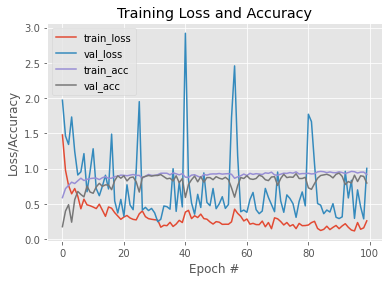

In [45]:
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()